# Определим нужные пути к файлам
Это достаточно свободный вариант, у меня получилось примерно так

In [24]:
APIMODEL_PATH = 'models'
ANNOTATION_PATH = 'ann'
IMAGE_PATH = 'dataset'
MODEL_PATH = 'models'
PRETRAINED_MODEL_PATH = 'pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 1. Создадим классы которые будем распознавать

In [25]:
labels = [{'name':'Mask', 'id':1}, {'name':'NoMask', 'id':2}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Создаем TF records

In [26]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [4]:
!python {'/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record


In [5]:
!python {'/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 3. Далее нам необходимо скачать предобученную модель из репозитория Tensorflow

In [6]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [27]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [8]:
!mkdir {'models\\'+CUSTOM_MODEL_NAME}

In [9]:
!mkdir {'models\\'+CUSTOM_MODEL_NAME}
!cd {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

Џ®¤Ї ЇЄ  Ё«Ё д ©« Tensorflow\workspace\models\my_ssd_mobnet г¦Ґ бгйҐбвўгҐв.
‘ЁбвҐ¬Ґ ­Ґ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© Їгвм.


# 5. Давайте обновим паплайн на необходимые параметры для нашего трансферного обучения

In [28]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [29]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [30]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [31]:
config

{'model': ssd {
   num_classes: 2
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
    

In [12]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [13]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [14]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Обучаем нашу модельку

In [28]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=100""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=100


# 7. Также можно загрузить тренировочные чекпоинты дабы сохранить наш прогресс обучения

In [32]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [33]:
from object_detection.utils import metrics

In [34]:
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Давайте протестируем модель

In [18]:
!pip install opencv-contrib-python

In [13]:
import cv2 
import numpy as np

In [35]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [36]:
category_index

{1: {'id': 1, 'name': 'Mask'}, 2: {'id': 2, 'name': 'NoMask'}}

In [12]:
def draw_label(img, text, pos, bg_color):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1.0
    color = (0, 0, 0)
    thickness = cv2.FILLED
    margin = 2

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin

    cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 1, cv2.LINE_AA)


In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

In [26]:
def decode_image(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image_resized = tf.image.resize_images(image, [224, 224])

    return img

## Решил загрузить еще дополнительно модельку бинарной классификации - человек/не человек

In [12]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    return 1

def precision_m(y_true, y_pred):
    return 1

def f1_m(y_true, y_pred):
    return 1

In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import PIL
model = tf.keras.models.load_model(r'C:\Users\Irina\Desktop\my_model_classification1', custom_objects={'f1_m':f1_m(0.5,0.4), 'precision_m':precision_m(0.5,0.3), 'recall_m':recall_m(0.3,0.1)})
#https://stackoverflow.com/questions/61767723/get-config-missing-while-loading-previously-saved-model-without-custom-layers

In [19]:
from tensorflow im3port keras
from tensorflow.keras.callbacks import TensorBoard

# Датасет состоит из 60 картинок поэтому модель Mask_Detection не особо точная, именно в этом варианте. Переобучать на большем кол-ве картинок и шагов или эпох достаточно долго и нудно =)

36
Mask
[0.84486884 0.5314726  0.35189283 0.31748396 0.30688506 0.28131694
 0.2611493  0.19716969 0.16700307 0.15938503 0.15284988 0.14397776
 0.12462562 0.1144824  0.11398342 0.1123521  0.11064935 0.11054903
 0.09624124 0.09500602 0.09376559 0.09312293 0.09102339 0.08586466
 0.08468238 0.08467552 0.08330551 0.08140019 0.0788449  0.07864475
 0.07846439 0.07697931 0.07371035 0.06882882 0.06817532 0.06689355
 0.06604934 0.06585032 0.06555986 0.06493801 0.06476972 0.06400105
 0.06343904 0.05943596 0.05927226 0.05925292 0.0591796  0.05895466
 0.05858472 0.05849761 0.05843854 0.05708066 0.05685261 0.05666038
 0.05640212 0.05594575 0.0552848  0.05423799 0.05358753 0.05303925
 0.05280802 0.0520781  0.05173692 0.05160084 0.05153751 0.05116463
 0.05028284 0.05020455 0.0499371  0.04929274 0.04836556 0.04781792
 0.04775578 0.04732537 0.04715163 0.04685619 0.04609567 0.04600358
 0.04584035 0.04571483 0.04498914 0.0448032  0.04473025 0.04460022
 0.04437679 0.04426873 0.04415074 0.04391235 0.0431993

<ipython-input-37-82e043ff6ef8>:40: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


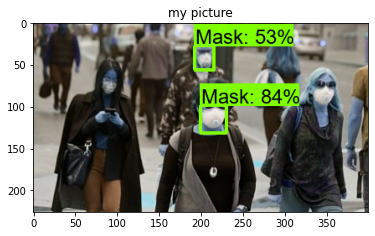

In [37]:
import numpy as np

image_path = r'C:\Users\Irina\Desktop\MaskDetection\maksssksksss53.jpg'
img = cv2.imread(image_path)
image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}

detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
label_id_offset = 1
image_np_with_detections = image_np.copy()
print(np.argmax(detections['detection_classes'], axis=0))
detections['detection_scores'].shape
viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=3,
                    min_score_thresh=0.5,
                    agnostic_mode=False)
if detections['detection_classes'][0] == 1: #нулевой элемент - предсказанный класс имеющий наибольшую вероятность
    print('NoMask')
if detections['detection_classes'][0] == 0:
    print('Mask')
    #cv2.resize(image_np_with_detections, (1000, 800))
print(detections['detection_scores']) #каждая предсказанная вероятность соответсвует каждому классу(100)
print(detections['detection_classes'])#предсказанные классы(100 штук)
#узнаем реальный класс, сделав простые анностации из 0или1 к каждому изображению
#далее прогоним валидационные данные по циклу и найдем accuerance, precision,recall,f score
#numpy.argmax(detections['detection_scores'], axis=0)
plt.imshow(image_np_with_detections)
plt.title('my picture')
plt.show()

Note that you are passing use_normalized_coordinates=True. If you trace the function calls, you will see your numbers [ 0.56213236,  0.2780568 ,  0.91445708,  0.69120586] etc. are the values [ymin, xmin, ymax, xmax] where the image coordinates: 

(left, right, top, bottom) = (xmin * im_width, xmax * im_width, 
                              ymin * im_height, ymax * im_height)
                          used normalization
                          so we can get the real coordinates
                          
#https://stackoverflow.com/questions/48915003/get-the-bounding-box-coordinates-in-the-tensorflow-object-detection-api-tutorial

# Здесь я решил протестировать несколько нейросеток для своего проекта:
1) Оставлю Mask Detection(потом потребуется переобучить для локализации человека)
2) Создал нейросетку и обучил для определения человек на снимке или же нет.
3) Создал область интересов - рамку.

## После переобучения и добавления пары фичей должен получится хороший проект для продакшн(пока что все в разработке)

NoMask
Человек входит в область интересов
429.51129376888275    521


<ipython-input-199-9622576526cb>:131: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


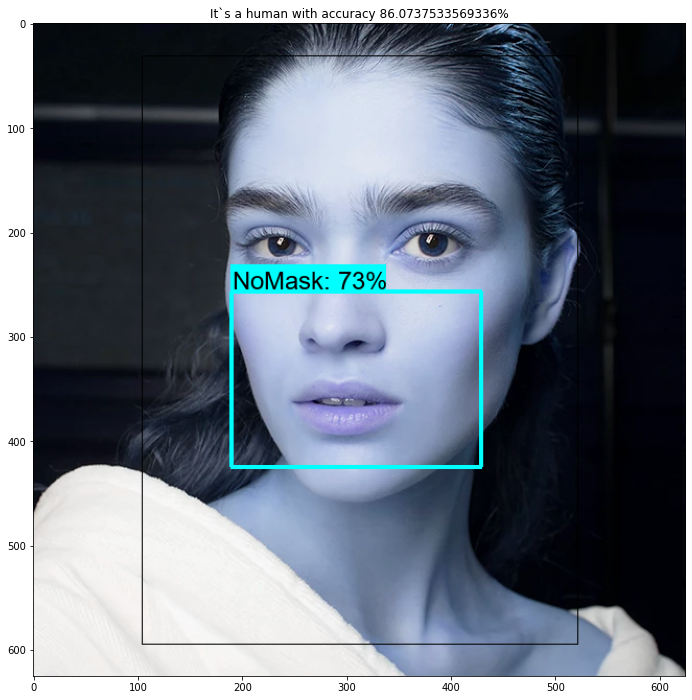

In [199]:
import numpy as np


from tensorflow.keras.preprocessing import image

image_path = r'C:\Users\Irina\Desktop\MaskDetection\qqq.jpg'

img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)



# resize image

img_2 = image.load_img(image_path, target_size=(180, 180))

image_np = np.array(img)
x = image.img_to_array(img_2)

x = np.expand_dims(x, axis=0)

images_2 = np.vstack([x])

classes = model.predict(images_2, batch_size=10)

if classes[0] < 0.5:
    result = "It`s a human with accuracy {}%".format(float((1 - classes[0])*100))
    #if class_names[np.argmax(score2)] == 'sunflowers':
    #  print('Урааа!')
else:
    result = "It`s a no human with accuracy {}%".format(float(classes[0]*100))

    
#image = plt.imread(image_file)

fig, ax = plt.subplots() #for change image size

#ax.imshow(image)
#ax.set_title(type(image))

#fig.set_figwidth(7)    
#fig.set_figheight(7)




input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}

detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
label_id_offset = 1
image_np_with_detections = image_np.copy()
#print(np.argmax(detections['detection_classes'], axis=0))
detections['detection_scores'].shape
viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=3,
                    min_score_thresh=0.5,
                    agnostic_mode=False)
if detections['detection_classes'][0] == 1: #нулевой элемент - предсказанный класс имеющий наибольшую вероятность
    print('NoMask')
if detections['detection_classes'][0] == 0:
    print('Mask')
    #cv2.resize(image_np_with_detections, (1000, 800))
#print(detections['detection_scores']) #каждая предсказанная вероятность соответсвует каждому классу(100)
#print(detections['detection_classes'])#предсказанные классы(100 штук)
#узнаем реальный класс, сделав простые анностации из 0или1 к каждому изображению
#далее прогоним валидационные данные по циклу и найдем accuerance, precision,recall,f score
#numpy.argmax(detections['detection_scores'], axis=0)
#plt.imshow(image_np_with_detections)#image_np_with_detections
#plt.title(result)

#ax.imshow(ret)#image_np_with_detections
ax.set_title(result)
#print('ля это шейп ',img.shape[0])
#roi = img[100:200, 100:200]
#coord = img.sh * detections['detection_boxes'][0][0]

blac = np.zeros((img.shape[0], img.shape[1], 3), np.uint8) #---black in RGB
#print(black)
#print(img.shape[0])
#print(img.shape[1])
#if coord[0] <
height, width = img.shape[:2]# width and height of the image

y1_min_box = height * detections['detection_boxes'][0][0]
x1_min_box = width * detections['detection_boxes'][0][1]

y2_max_box = height * detections['detection_boxes'][0][2]
x2_max_box = width * detections['detection_boxes'][0][3]

#print(height)
#print(width)
if  height>width:
    x1_min_mask = int(width/6.0) #(x1,y1) - самая верняя левая точка
    y1_min_mask = int(height/20.0)
    x2_max_mask = int(width - x1_min_mask)#симмитричная сторона 
    y2_max_mask = int(height - y1_min_mask) #(x2,y2) - самая нижняя правая точка
else:
    x1_min_mask = int(width/6.0)
    y1_min_mask = int(height/20.0)
    x2_max_mask = int(width - x1_min_mask)#симмитричная сторона
    y2_max_mask = int(height - y1_min_mask)
#print(x1,' ',y1 , ' x2 = ',x2, ' y2 = ',y2)
mask = cv2.rectangle(image_np_with_detections,(x1_min_mask,y1_min_mask),(x2_max_mask,y2_max_mask), -1)   #---the dimension of the ROI(255, 255, 255)
#if x1_mask<
#gray = cv2.cvtColor(black,cv2.COLOR_BGR2GRAY)               #---converting to gray
#ret,b_mask = cv2.threshold(gray,127,255, 0)                 #---converting to binary image
ax.imshow(mask)
#fin = cv2.bitwise_and(th,th,mask = mask)

#print('y1_min_box = ' + str(y1_min_box) + ', x1_min_box = ' + str(x1_min_box) + ', y2_max_box = '+str(y2_max_box)+ ', y2_max_box = '+str(y2_max_box))
if (x1_min_box > x1_min_mask) and (y1_min_box > y1_min_mask) and (x2_max_box < x2_max_mask) and (y2_max_box < y2_max_mask):
    #draw_text(image_np_with_detections, 'It`s not a person', (150,150), (255,0,0))
    print('Человек входит в область интересов')
else:
    print('Человек не входит в область интересов')

print(str(x2_max_box)+ '    ' + str(x2_max_mask))
fig.set_figwidth(12)    
fig.set_figheight(12)

plt.show()

#print(detections['detection_boxes'][0])

In [161]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

def draw_text(img, text, pos, bg_color):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 1.0
    color = (0, 0, 0)
    thickness = cv2.FILLED
    margin = 2

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin

    cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 1, cv2.LINE_AA)

# Показывает в реальном времени есть на человека маска или же нет. Если человека(маски) нету в видеопотоке в какой-то момент времени то выводит, что человек неопределен на весь экран.

In [63]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor) #detect_fn производит препроцессинг и постпроцессинг 
                                         #изображения(изменяет размер и обратно)
    num_detections = int(detections.pop('num_detections'))
    
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    #if detections['detection_scores'][0] > 0.8 :
    if detections['detection_classes'][0] == 0:
        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=1,
                    min_score_thresh=0.9,
                    agnostic_mode=False)
    else:
        draw_text(image_np_with_detections, 'It`s not a person', (150,150), (255,0,0))
  
    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (1000, 800)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('c3.png',frame)
        cap.release()
        cv2.destroyAllWindows()
        break

